<a href="https://colab.research.google.com/github/abagnard/266FinalProject/blob/main/W266_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:

import os, sys, re, csv, json, time, unittest
import itertools, collections
from importlib import reload

import numpy as np
from scipy import stats
import pandas as pd

import nltk



# FOMC Data Loader

## Scrape FOMC Data

#### Links to Data:
**Start-2014:** https://www.federalreserve.gov/monetarypolicy/fomc_historical_year.htm
**2015-2020:** https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm

#### 2010-2020 General Link Format:
  **Statement/Press Release:** https://www.federalreserve.gov/newsevents/pressreleases/monetaryYYYYMMDDa.htm
   **Minutes:** https://www.federalreserve.gov/monetarypolicy/fomcminutesYYYYMMDD.htm

In [2]:
from   bs4    import BeautifulSoup
from   urllib.request import urlopen

# Create URLs
def getFOMCStatementURL(date):
  if date >= 20100000:
    url = "https://www.federalreserve.gov/newsevents/pressreleases/monetary" + str(date) + "a.htm"
  return url

def getFOMCMinutesURL(date):
  if date >= 20100000:
    url = "https://www.federalreserve.gov/monetarypolicy/fomcminutes" + str(date) + ".htm"
  return url

# Pull Data from URL
def getFOMCStatementData(date):
    html = urlopen(getFOMCStatementURL(date)).read()
    soup = BeautifulSoup(html)
    text = soup.get_text(" ")
    if int(date) < 20200400:
        startLocation = re.search("Information received since", text).start()
    else:
        startLocation = re.search("The Federal Reserve is committed", text).start()
    endLocation = re.search("Voting for", text).start()

    statementText = text[startLocation : endLocation]
    return statementText

def getFOMCMinutesData(date):
  html = urlopen(getFOMCMinutesURL(date)).read()
  soup = BeautifulSoup(html)
  text = soup.get_text(" ")

  startLocation = re.search("Minutes of the Federal Open Market Committee", text).start() + len("Minutes of the Federal Open Market Committee")
  endLocation = re.search("notation vote", text).start()

  minutesText = text[startLocation : endLocation]
  return minutesText


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')


In [4]:
# dates = [20100127
# ,20100316
# ,20100428]
# for date in dates:
#   print("Statement on ", date)
#   print(getFOMCStatementData(date))


# for date in dates:
#   print("Minutes on ", date)
#   print(getFOMCMinutesData(date))


### Code for Google Colab
#### Pulls Dates from Google Sheets

In [5]:
# Code Source
# https://medium.com/analytics-vidhya/colab-and-google-sheets-surprisingly-powerful-combination-for-data-science-part-1-bbbb11cbd8e

# from google.colab import auth
# auth.authenticate_user()
# import gspread
# from oauth2client.client import GoogleCredentials
# gc = gspread.authorize(GoogleCredentials.get_application_default())

In [30]:
# date_google_sheet_url = gc.open_by_url("https://docs.google.com/spreadsheets/d/1Q9_JimVaDffFe8U4SYQ_VLU9-1aeuFXlDZhvTsFD0kg/edit#gid=1023419829")
# date_google_sheet = date_google_sheet_url.worksheet("Dates")
# date_data_raw = date_google_sheet.get_all_values()

# df_date = pd.DataFrame(date_data_raw)
# df_date.columns = df_date.iloc[0]
# df_date = df_date.iloc[1:]

# df_date.head()
# dates = df_date["Date"].values.tolist()

#### Create Raw Text Files

In [8]:
# Pull Dates of FOMC meetings
df_date = pd.read_csv("data/FOMC_data/FOMC_meeting_dates.csv")
df_date.head()

# Functions to create Statement and Minute Text Files
def createFOMCStatementTextFile(file_path):
#   file_path = "/content/drive/My Drive/W266 - NLP/Final Project/data/FOMC_data/FOMC_Raw/"
#     file_path = "data/FOMC_data/FOMC_data_raw/"
    for date in dates:
        print("Creating Text File: Statement - ", date)
        data = getFOMCStatementData(date)
        filename = "FOMCStatement_" + str(date) + ".txt"
        file = open(file_path+filename, "w")
        file.write(data)
        file.close
        
def createFOMCMinutesTextFile(file_path):
#   file_path = "/content/drive/My Drive/W266 - NLP/Final Project/data/FOMC_data/FOMC_Raw/"
#     file_path = "data/FOMC_data/FOMC_data_raw/"
    for date in dates:
        print("Creating Text File: Minute - ", date)
        data = getFOMCMinutesData(date)
        filename = "FOMCMinutes_" + str(date) + ".txt"
        file = open(file_path+filename, "w")
        file.write(data)
        file.close
        
# createFOMCStatementTextFile(file_path = "data/FOMC_data/FOMC_data_raw/")
# createFOMCMinutesTextFile(file_path = "data/FOMC_data/FOMC_data_raw/")

In [31]:
# from google.colab import drive
# drive.mount('/content/drive')
# cd /content/drive/'My Drive'/'W266 - NLP'/'Final Project'

## Clean Raw Text Files
- Removes punctuation and stop words
- Renames "federal open market committee" and "the committee" as "FOMC"
- Creates clean text files where text is all lowercase

In [32]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import glob

def cleanFOMCDocument(raw_file_name):
    raw_data = open(raw_file_name,"r").read().lower()
    clean_data = raw_data
    
    #remove punctuation, stopwords and returns test as lowercase words
#     for todelete in ["\r\n", "\n", "\t", ",", "-", ";", ":", "  "]:
#         clean_data = clean_data.replace(todelete, ' ')
        
    tokenizer = RegexpTokenizer(r'\w+')
    clean_data = tokenizer.tokenize(clean_data)
    
    clean_data = [word for word in clean_data if word not in stopwords.words('english')]
    clean_data = " ".join(clean_data)
    
    clean_data = clean_data.replace("federal open market committee", "FOMC")
    clean_data = clean_data.replace("the committee", "the FOMC")
    return clean_data


def createCleanFOMCTextFiles(raw_file_names):
    file_path = 'data/FOMC_data/FOMC_data_clean/'
    
    for raw_file_name in raw_file_names:
        file_name = raw_file_name.split('/')[-1]
        print("Creating Text File: ", file_name)
        data = cleanFOMCDocument(raw_file_name)

        file = open(file_path+file_name, "w")
        file.write(data)
        file.close
        
raw_file_names = glob.glob('data/FOMC_data/FOMC_data_raw/*.txt')
# createCleanFOMCTextFiles(raw_file_names)


## Create DataFrame with Clean Data
- Includes press_conference flag that denotes whether a press conference was held for that FOMC meeting

In [11]:
clean_file_names = glob.glob('data/FOMC_data/FOMC_data_clean/*.txt')

FOMC_records = []
for clean_file_name in clean_file_names:
    date = clean_file_name.split('/')[-1].split('_')[-1][:-4]
    file_type = 'minutes' if 'Minutes' in clean_file_name else 'statement'
    press_conference = df_date[df_date['Date'] == int(date)].iloc[0]['PressConference']
    data = open(clean_file_name).read()
    
    FOMC_record = {'FOMC_date': date, 'document_type': file_type, 'press_conference': press_conference, 'document_data': data}
    FOMC_records.append(FOMC_record)


df_FOMC = pd.DataFrame(FOMC_records)

In [12]:
df_FOMC.FOMC_date = pd.to_datetime(df_FOMC.FOMC_date, format='%Y%m%d')
df_FOMC.head()

,FOMC_date,document_data,document_type,press_conference
0,2011-01-26,information received since the federal open ma...,statement,0
1,2013-06-19,information received since the federal open ma...,statement,1
2,2017-07-26,july 25 26 2017 a joint meeting of the fed...,minutes,0
3,2017-02-01,information received since the federal open ma...,statement,0
4,2018-01-31,information received since the federal open ma...,statement,0


In [13]:
df_FOMC.describe(include='all')

,FOMC_date,document_data,document_type,press_conference
count,172,172,172,172.000000
unique,86,172,2,NaN
top,2018-01-31 00:00:00,information received since the federal open ma...,minutes,NaN
freq,2,1,86,NaN
first,2010-01-27 00:00:00,NaN,NaN,NaN
last,2020-09-16 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.534884
std,NaN,NaN,NaN,0.500238
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,0.000000


# Top 20 Most Common Words

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 20)

cv.fit(df_FOMC['document_data'])
top_20_words_all = cv.get_feature_names()

top_20_words_all = pd.DataFrame(top_20_words_all)
top_20_words_all.columns = ['Top 20 Words']
top_20_words_all

# top_20 = pd.DataFrame(results.toarray(). columns=features)

,Top 20 Words
0,and
1,as
2,at
3,committee
4,economic
5,federal
6,for
7,in
8,inflation
9,market


# FOMC Word Cloud

### FOMC Statements & Minutes Word Cloud

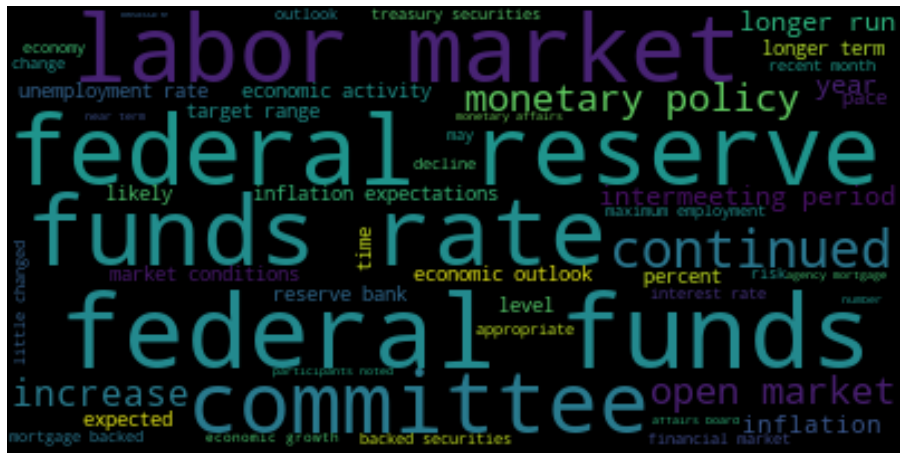

In [57]:
# pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

text = ' '.join(df_FOMC['document_data'])
wordcloud = WordCloud(max_words=50).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/all_FOMC_docs_wordcloud.png")

### FOMC Statements Word Cloud

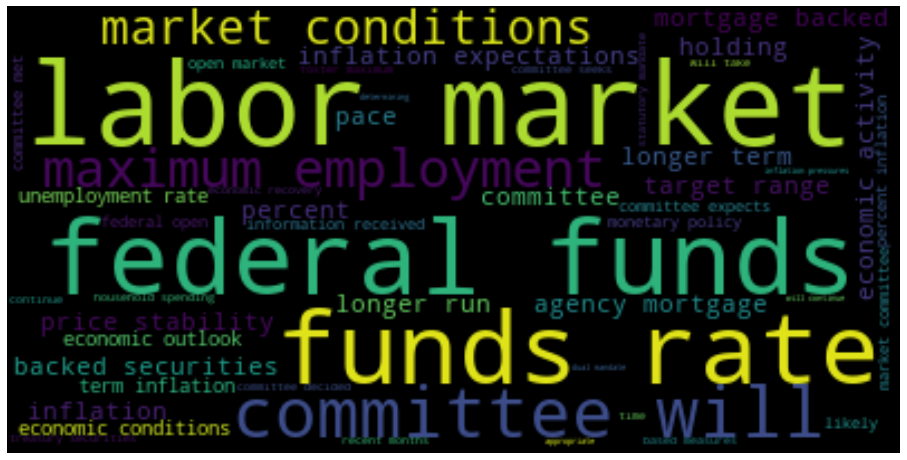

In [59]:
statements = df_FOMC[df_FOMC['document_type'] == 'statement']

plt.figure(figsize=(16, 10))

statement_text = ' '.join(statements['document_data'])
statement_wordcloud = WordCloud(max_words=50).generate(statement_text)
plt.imshow(statement_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_statements_wordcloud.png")

### FOMC Minutes Word Cloud

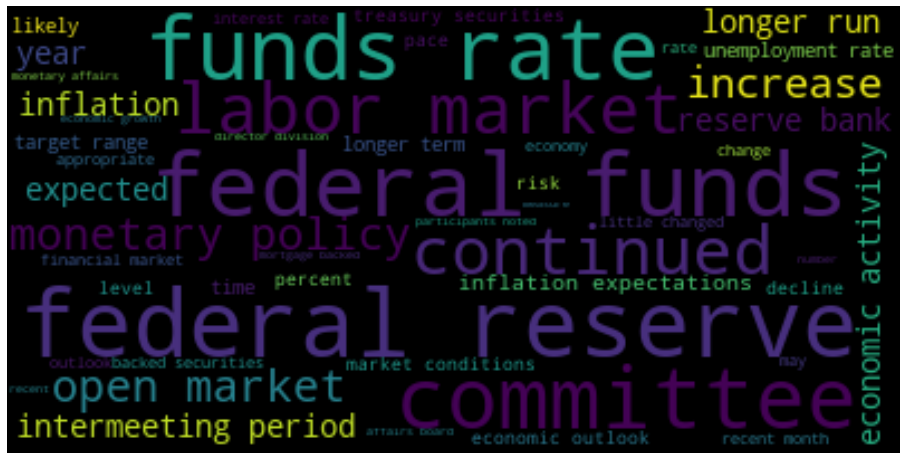

In [60]:
minutes = df_FOMC[df_FOMC['document_type'] == 'minutes']

plt.figure(figsize=(16, 10))

minute_text = ' '.join(minutes['document_data'])
minute_wordcloud = WordCloud(max_words=50).generate(minute_text)
# minute_wordcloud = WordCloud(max_words=50, background_color='white').generate(minute_text)
plt.imshow(minute_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_minutes_wordcloud.png"

# Document Sentiment Analysis

#### Load Loughran-McDonald Postive & Negative Word Lists
source: https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists

In [28]:
def createLoughranMcDonaldWordList(file_name):
    file = open('data/LoughranMcDonald/'+file_name, "r")
    words = file.readlines()
    words = [word.strip().lower() for word in words]
    return words

LM_negative_words = createLoughranMcDonaldWordList('LoughranMcDonald_NegativeWordList.csv')
LM_postive_words = createLoughranMcDonaldWordList('LoughranMcDonald_PositiveWordList.csv')

#### Count Positive and Negative Words in Each Document to Calculate Sentiment Score

In [37]:
def calcSentiment(document_data):
    words = document_data.split(' ')
    positive_count = len([word for word in words if word in LM_postive_words])
    negative_count = len([word for word in words if word in LM_negative_words])
    sentiment_score = positive_count - negative_count
    return sentiment_score

df_FOMC['sentiment_score'] = df_FOMC['document_data'].apply(lambda data: calcSentiment(data))

In [62]:
df_FOMC.sort_values(['FOMC_date', 'document_type']).head()

,FOMC_date,document_data,document_type,press_conference,sentiment_score
115,2010-01-27,january 26 27 2010 fomc minutes summar...,minutes,0,-77
39,2010-01-27,information received since the federal open ma...,statement,0,4
55,2010-03-16,march 16 2010 fomc minutes ...,minutes,0,-81
147,2010-03-16,information received since the federal open ma...,statement,0,1
38,2010-04-28,april 27 28 2010 fomc minutes ...,minutes,0,-48


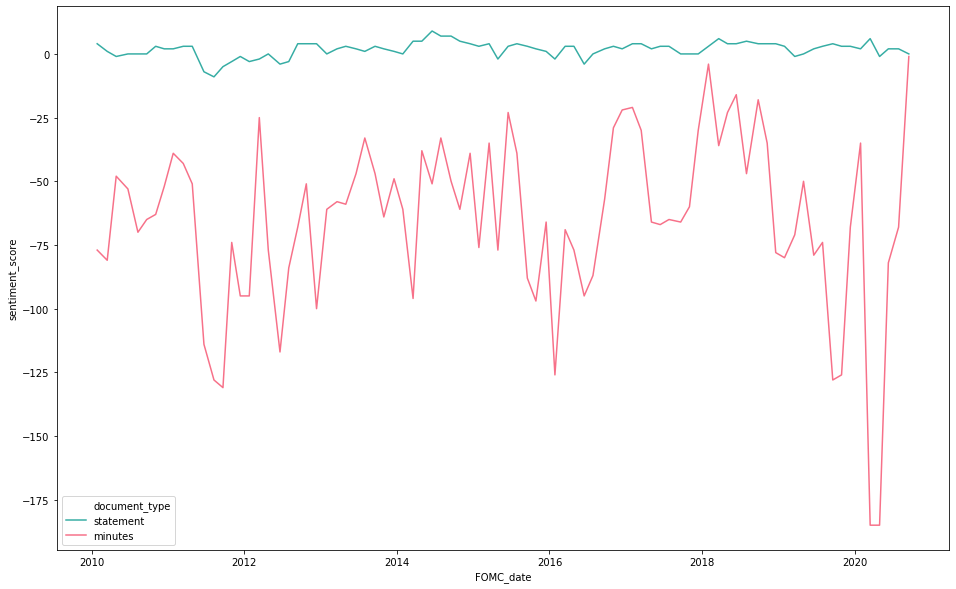

In [61]:

df_FOMC.sort_values(['FOMC_date', 'document_type']).head()

import seaborn as sns
colors = sns.color_palette('husl', n_colors =2)
color_map = dict(zip(['minutes','statement'], colors))

plt.figure(figsize=(16, 10))
sns.lineplot(x=df_FOMC['FOMC_date'], y=df_FOMC['sentiment_score'], hue=df_FOMC['document_type'], palette=color_map)


Fed Release

Financial News Sources